In [2]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import necessary libraries for data handling, model building, and visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
# Set random seed for consistent results
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
# Define paths to training, testing, and validation datasets
train_dir = "/content/drive/MyDrive/Chest X-Ray Images/data_set/train"
test_dir = "/content/drive/MyDrive/Chest X-Ray Images/data_set/test"
val_dir = "/content/drive/MyDrive/Chest X-Ray Images/data_set/val"

In [6]:
# Data preprocessing with ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to 0-1
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.2,    # Shift width randomly
    height_shift_range=0.2,   # Shift height randomly
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Flip horizontally
    fill_mode='nearest'       # Fill empty pixels
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation/test

IMG_SIZE = (224, 224)  # Image size for CNN
BATCH_SIZE = 32        # Number of images per batch

# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # 0 = Normal, 1 = Pneumonia
    shuffle=True
)
# Load and preprocess validation data
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load and preprocess test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Keep order for evaluation
)

Found 2937 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
# Build the CNN model
model = Sequential([
    # Layer 1: Extract basic features
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 2: Extract more complex features
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 3: Deep feature extraction
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the features into a vector
    Flatten(),

    # Dense layer to learn patterns
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent overfitting

    # Output layer: 0 or 1
    Dense(1, activation='sigmoid')
])

# Compile the model with optimizer and loss function
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
EPOCHS = 10  # Number of training rounds
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1  # Show progress
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1478s 16s/step - accuracy: 0.6176 - loss: 0.7711 - val_accuracy: 0.6875 - val_loss: 0.6028
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 881ms/step - accuracy: 0.8274 - loss: 0.4063 - val_accuracy: 0.8125 - val_loss: 0.5543
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 884ms/step - accuracy: 0.8441 - loss: 0.4046 - val_accuracy: 0.6250 - val_loss: 0.6199
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 880ms/step - accuracy: 0.8587 - loss: 0.3766 - val_accuracy: 0.8125 - val_loss: 0.5545
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 884ms/step - accuracy: 0.8685 - loss: 0.3494 - val_accuracy: 0.5625 - val_loss: 0.9592
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 890ms/step - accuracy: 0.8807 - loss: 0.3056 - val_accuracy: 0.6875 - val_loss: 0.6178
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 894ms/step - accuracy: 0.9053 - loss: 0.2727 - val_accuracy: 0.7500 - val_loss: 0.5582
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 943ms/step - accuracy: 0.8868 - loss: 0.2719 - val_accu

In [9]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
test_generator.reset()
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

# Confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 274s 14s/step - accuracy: 0.6617 - loss: 0.6348
Test Accuracy: 0.8109
Test Loss: 0.3958
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 313ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.55      0.68       234
   Pneumonia       0.78      0.97      0.86       390

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.77       624
weighted avg       0.83      0.81      0.80       624



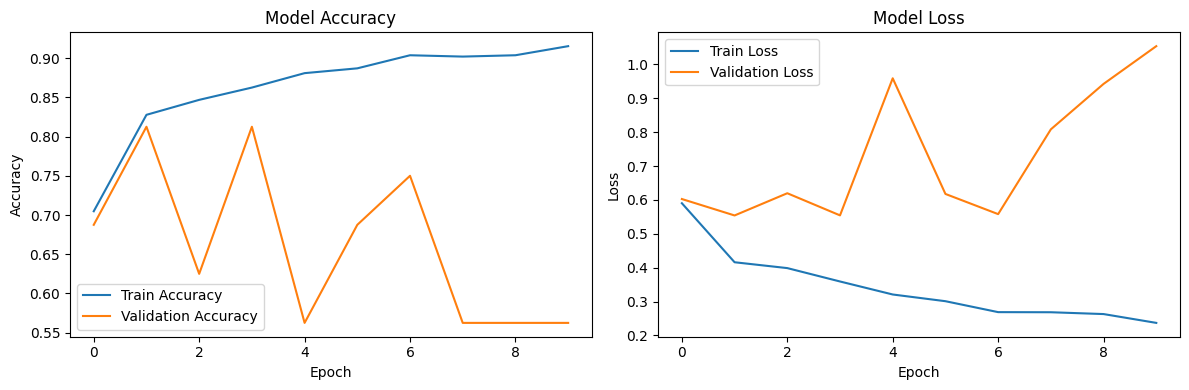

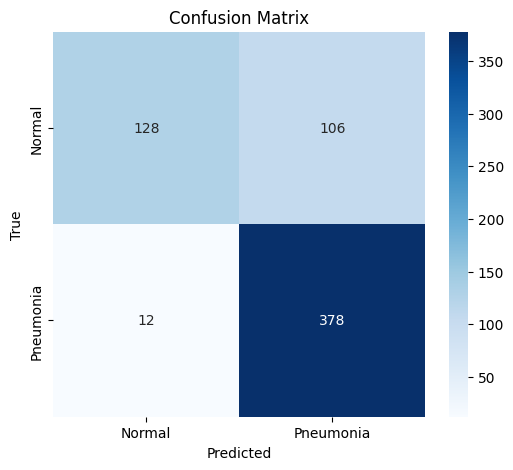

In [10]:
# Plot training/validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
# Save the model to Google Drive
model.save('/content/drive/MyDrive/Chest X-Ray Images/pneumonia_detection_model.h5')

In [12]:
model.save('/content/drive/MyDrive/Chest X-Ray Images/pneumonia_detection_model.keras')